# train 

## 必要モジュールのインポート

In [1]:
# データオーグメンテーション用の fmix・モデル用のtimmの準備
import os
if not os.path.exists('/home/gala/input/image-fmix/FMix-master/fmix.zip'):
    os.makedirs("/home/gala/input/image-fmix/FMix-master/", exist_ok=True)
    os.chdir('/home/gala/input/image-fmix/FMix-master')
    !wget -O fmix.zip https://github.com/ecs-vlc/fmix/archive/master.zip
    !unzip -qq fmix.zip
    !mv FMix-master/* ./
    !rm -r FMix-master
    os.chdir('/home/gala/working')
    
package_paths = [
    #'../input/pytorch-image-models/pytorch-image-models-master', #'../input/efficientnet-pytorch-07/efficientnet_pytorch-0.7.0'
    '../input/image-fmix/FMix-master'
]
import sys; 
for pth in package_paths:
    sys.path.append(pth)
    
from fmix import sample_mask, make_low_freq_image, binarise_mask

In [2]:
#timm 一回だけ
#!pip install timm

In [3]:
from glob import glob
from sklearn.model_selection import GroupKFold, StratifiedKFold
import cv2
from skimage import io
import torch
from torch import nn
import os
from datetime import datetime
import time
import random
import cv2
import torchvision
from torchvision import transforms
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
from torch.cuda.amp import autocast, GradScaler
from torch.nn.modules.loss import _WeightedLoss
import torch.nn.functional as F

import timm

import sklearn
import warnings
import joblib
from sklearn.metrics import roc_auc_score, log_loss
from sklearn import metrics
import warnings
import cv2
import pydicom
#from efficientnet_pytorch import EfficientNet
from scipy.ndimage.interpolation import zoom

## パラメータ

In [4]:
CFG = {
    'fold_num': 5,
    'seed': 719,
    'model_arch': 'tf_efficientnet_b4_ns', # パラメータが少ない割に性能が高い　https://www.opensourceagenda.com/projects/gen-efficientnet-pytorch
    'img_size_h': 235,
    'img_size_w': 80,
    'epochs': 10,
    'train_bs': 128,
    'valid_bs': 256,
    'T_0': 10,
    'lr': 1e-4,
    'min_lr': 1e-6,
    'weight_decay':1e-6,
    'num_workers': 4,
    'accum_iter': 2, # suppoprt to do batch accumulation for backprop with effectively larger batch size
    'verbose_step': 1,
    'device': 'cuda:0'
}

## train の正解ラベルとサンプル

In [18]:
train_with_misc = pd.read_csv("../input/gala-images-classification/dataset/train.csv")
# misc は特殊なものとして扱う
train_with_misc["is_misc"] = (train_with_misc["Class"]=="misc")*1
label_dic = {"Attire":0, "Food":1, "Decorationandsignage":2,"misc":3}
train_with_misc["label"]=train_with_misc["Class"].map(label_dic)
train_with_misc.head()

,Image,Class,is_misc,label
0,image4.jpg,Attire,0,0
1,image7.jpg,misc,1,3
2,image10.jpg,Food,0,1
3,image11.jpg,Decorationandsignage,0,2
4,image13.jpg,Decorationandsignage,0,2


In [8]:
submission = pd.read_csv("../input/gala-images-classification/dataset/sample_submission.csv", index_col=0)
submission.head()

,Image,Class
0,image9000.jpg,Food
1,image9001.jpg,Food
2,image9003.jpg,Food
3,image9007.jpg,Food
4,image9008.jpg,Food


## 便利な関数（Helper Functions）

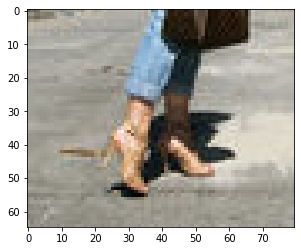

In [9]:
def seed_everything(seed):
    "seed値を一括指定"
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True
    
def get_img(path):
    """
    pathからimageの配列を得る
    """
    im_bgr = cv2.imread(path)
    im_rgb = im_bgr[:, :, ::-1]
    #print(im_rgb)
    return im_rgb

img = get_img('../input/gala-images-classification/dataset/Train_Images/image4.jpg')
plt.imshow(img)
plt.show()

## Dataset

In [10]:
def rand_bbox(size, lam):
    """
    ランダムなボックスを出力する
    lam の大きさに従って、ランダムな位置でカットした正方形を出力する。はみ出たらクリップしてカット
    """
    W = size[0]
    H = size[1]
    cut_rat = np.sqrt(1. - lam)
    cut_w = np.int(W * cut_rat)
    cut_h = np.int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)
    return bbx1, bby1, bbx2, bby2

In [11]:

class GalaDataset(Dataset):
    def __init__(self, df, data_root, 
                 transforms=None, 
                 output_label=True, 
                 one_hot_label=False,
                 do_fmix=False, 
                 fmix_params={
                     'alpha': 1., 
                     'decay_power': 3., 
                     'shape': (CFG['img_size_h'], CFG['img_size_w']),
                     'max_soft': True, 
                     'reformulate': False
                 },
                 do_cutmix=False,
                 cutmix_params={
                     'alpha': 1,
                 },
                 image_name_col = "Image",
                 label_col = "label"
                ):
        
        super().__init__()
        self.df = df.reset_index(drop=True).copy()
        self.transforms = transforms
        self.data_root = data_root
        self.do_fmix = do_fmix
        self.fmix_params = fmix_params
        self.do_cutmix = do_cutmix
        self.cutmix_params = cutmix_params
        
        self.output_label = output_label
        self.one_hot_label = one_hot_label
        self.image_name_col = image_name_col
        self.label_col = label_col
        
        if output_label == True:
            self.labels = self.df[self.label_col].values
            #print(self.labels)
            
            if one_hot_label is True:
                self.labels = np.eye(self.df[self.label_col].max()+1)[self.labels]
                #print(self.labels)
            
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, index: int):
        
        # get labels
        if self.output_label:
            target = self.labels[index]
          
        img  = get_img("{}/{}".format(self.data_root, self.df.loc[index][self.image_name_col]))

        if self.transforms:
            img = self.transforms(image=img)['image']
        
        if self.do_fmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            with torch.no_grad():
                #lam, mask = sample_mask(**self.fmix_params)
                
                lam = np.clip(np.random.beta(self.fmix_params['alpha'], self.fmix_params['alpha']),0.6,0.7)
                
                # Make mask, get mean / std
                mask = make_low_freq_image(self.fmix_params['decay_power'], self.fmix_params['shape'])
                mask = binarise_mask(mask, lam, self.fmix_params['shape'], self.fmix_params['max_soft'])
    
                fmix_ix = np.random.choice(self.df.index, size=1)[0]
                fmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[fmix_ix][self.image_name_col]))

                if self.transforms:
                    fmix_img = self.transforms(image=fmix_img)['image']

                mask_torch = torch.from_numpy(mask)
                
                # mix image
                img = mask_torch*img+(1.-mask_torch)*fmix_img

                #print(mask.shape)

                #assert self.output_label==True and self.one_hot_label==True

                # mix target
                rate = mask.sum()/CFG['img_size_h']/CFG['img_size_w']
                target = rate*target + (1.-rate)*self.labels[fmix_ix]
                #print(target, mask, img)
                #assert False
        
        if self.do_cutmix and np.random.uniform(0., 1., size=1)[0] > 0.5:
            #print(img.sum(), img.shape)
            with torch.no_grad():
                cmix_ix = np.random.choice(self.df.index, size=1)[0]
                cmix_img  = get_img("{}/{}".format(self.data_root, self.df.iloc[cmix_ix]['image_id']))
                if self.transforms:
                    cmix_img = self.transforms(image=cmix_img)['image']
                    
                lam = np.clip(np.random.beta(self.cutmix_params['alpha'], self.cutmix_params['alpha']),0.3,0.4)
                bbx1, bby1, bbx2, bby2 = rand_bbox((CFG['img_size_h'], CFG['img_size_w']), lam)

                img[:, bbx1:bbx2, bby1:bby2] = cmix_img[:, bbx1:bbx2, bby1:bby2]

                rate = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (CFG['img_size_h'] * CFG['img_size_w']))
                target = rate*target + (1.-rate)*self.labels[cmix_ix]
                
            #print('-', img.sum())
            #print(target)
            #assert False
                            
        # do label smoothing
        #print(type(img), type(target))
        if self.output_label == True:
            return img, target
        else:
            return img

In [12]:
# transform
"""
大きさは、ひとまず縦235,横80の値にそろえるために、resize ではなく PadIfNeeded にする
"""


from albumentations import (
    PadIfNeeded, HorizontalFlip, VerticalFlip, IAAPerspective, ShiftScaleRotate, CLAHE, RandomRotate90,
    Transpose, ShiftScaleRotate, Blur, OpticalDistortion, GridDistortion, HueSaturationValue,
    IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, MedianBlur, IAAPiecewiseAffine, RandomResizedCrop,
    IAASharpen, IAAEmboss, RandomBrightnessContrast, Flip, OneOf, Compose, Normalize, Cutout, CoarseDropout, ShiftScaleRotate, CenterCrop, Resize
)

from albumentations.pytorch import ToTensorV2

def get_train_transforms():
    return Compose([
            PadIfNeeded(CFG['img_size_h'], CFG['img_size_w']),
            #RandomResizedCrop(CFG['img_size_h'], CFG['img_size_w']),
            #Transpose(p=0.5), # サイズを正方形にしないといけない
            HorizontalFlip(p=0.5),
            VerticalFlip(p=0.5),
            ShiftScaleRotate(p=0.5),
            HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit=0.2, val_shift_limit=0.2, p=0.5),
            RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            CoarseDropout(p=0.5),
            Cutout(p=0.5),
            ToTensorV2(p=1.0),
        ], p=1.)
  
        
def get_valid_transforms():
    return Compose([
            PadIfNeeded(CFG['img_size_h'], CFG['img_size_w']),
            #CenterCrop(CFG['img_size'], CFG['img_size'], p=1.),
            Resize(CFG['img_size_h'], CFG['img_size_w']),
            Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225], max_pixel_value=255.0, p=1.0),
            ToTensorV2(p=1.0),
        ], p=1.)

## Model

In [13]:
class GalaImgClassifier(nn.Module):
    def __init__(self, model_arch, n_class, pretrained=False):
        super().__init__()
        self.model = timm.create_model(model_arch, pretrained=pretrained)
        n_features = self.model.classifier.in_features
        self.model.classifier = nn.Linear(n_features, n_class)
        '''
        self.model.classifier = nn.Sequential(
            nn.Dropout(0.3),
            #nn.Linear(n_features, hidden_size,bias=True), nn.ELU(),
            nn.Linear(n_features, n_class, bias=True)
        )
        '''
    def forward(self, x):
        x = self.model(x)
        return x

## Training API

In [14]:
def prepare_dataloader(df, trn_idx, val_idx, data_root='../input/gala-images-classification/dataset/Train_Images'):
    """
    BalanceClassSampler を使ってデータローダーを作成する関数
    """
    
    from catalyst.data.sampler import BalanceClassSampler
    
    train_ = df.loc[trn_idx,:].reset_index(drop=True)
    valid_ = df.loc[val_idx,:].reset_index(drop=True)
        
    train_ds = GalaDataset(train_, data_root, transforms=get_train_transforms(), output_label=True, one_hot_label=False, do_fmix=False, do_cutmix=False)
    valid_ds = GalaDataset(valid_, data_root, transforms=get_valid_transforms(), output_label=True)
    
    train_loader = torch.utils.data.DataLoader(
        train_ds,
        batch_size=CFG['train_bs'],
        pin_memory=True, # faster and use memory
        drop_last=False,
        shuffle=True,        
        num_workers=CFG['num_workers'],
        #sampler=BalanceClassSampler(labels=train_['label'].values, mode="downsampling")
    )
    val_loader = torch.utils.data.DataLoader(
        valid_ds, 
        batch_size=CFG['valid_bs'],
        num_workers=CFG['num_workers'],
        shuffle=False,
        pin_memory=False,
    )
    return train_loader, val_loader

def train_one_epoch(epoch, model, loss_fn, optimizer, train_loader, device, scheduler=None, schd_batch_update=False):
    model.train()

    t = time.time()
    running_loss = None

    pbar = tqdm(enumerate(train_loader), total=len(train_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()

        #print(image_labels.shape, exam_label.shape)
        with autocast():
            image_preds = model(imgs)   #output = model(input)
            #print(image_preds.shape, exam_pred.shape)

            loss = loss_fn(image_preds, image_labels)
            
            scaler.scale(loss).backward()

            if running_loss is None:
                running_loss = loss.item()
            else:
                running_loss = running_loss * .99 + loss.item() * .01

            if ((step + 1) %  CFG['accum_iter'] == 0) or ((step + 1) == len(train_loader)):
                # may unscale_ here if desired (e.g., to allow clipping unscaled gradients)

                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad() 
                
                if scheduler is not None and schd_batch_update:
                    scheduler.step()

            if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(train_loader)):
                description = f'epoch {epoch} loss: {running_loss:.4f}'
                
                pbar.set_description(description)
                
    if scheduler is not None and not schd_batch_update:
        scheduler.step()
        
def valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False):
    model.eval()

    t = time.time()
    loss_sum = 0
    sample_num = 0
    image_preds_all = []
    image_targets_all = []
    
    pbar = tqdm(enumerate(val_loader), total=len(val_loader))
    for step, (imgs, image_labels) in pbar:
        imgs = imgs.to(device).float()
        image_labels = image_labels.to(device).long()
        
        image_preds = model(imgs)   #output = model(input)
        #print(image_preds.shape, exam_pred.shape)
        image_preds_all += [torch.argmax(image_preds, 1).detach().cpu().numpy()]
        image_targets_all += [image_labels.detach().cpu().numpy()]
        
        loss = loss_fn(image_preds, image_labels)
        
        loss_sum += loss.item()*image_labels.shape[0]
        sample_num += image_labels.shape[0]  

        if ((step + 1) % CFG['verbose_step'] == 0) or ((step + 1) == len(val_loader)):
            description = f'epoch {epoch} loss: {loss_sum/sample_num:.4f}'
            pbar.set_description(description)
    
    image_preds_all = np.concatenate(image_preds_all)
    image_targets_all = np.concatenate(image_targets_all)
    print('validation multi-class accuracy = {:.4f}'.format((image_preds_all==image_targets_all).mean()))
    
    if scheduler is not None:
        if schd_loss_update:
            scheduler.step(loss_sum/sample_num)
        else:
            scheduler.step()

In [15]:
train_with_misc[train_with_misc["Class"]!="misc"].reset_index(drop=True).head()

,Image,Class,is_misc,label
0,image4.jpg,Attire,0,0
1,image10.jpg,Food,0,1
2,image11.jpg,Decorationandsignage,0,2
3,image13.jpg,Decorationandsignage,0,2
4,image15.jpg,Food,0,1


## main

In [16]:
if __name__ == '__main__':
     # for training only, need nightly build pytorch
    
    # misc は除いて学習させる！！！
    train = train_with_misc[train_with_misc["Class"]!="misc"].reset_index(drop=True)

    seed_everything(CFG['seed'])
    
    folds = StratifiedKFold(n_splits=CFG['fold_num'], shuffle=True, random_state=CFG['seed']).split(np.arange(train.shape[0]), train.label.values)
    
    for fold, (trn_idx, val_idx) in enumerate(folds):
        # we'll train fold 0 first
        '''
        if fold > 0:
            break '''

        print('Training with {} started'.format(fold))

        print(len(trn_idx), len(val_idx))
        train_loader, val_loader = prepare_dataloader(train, trn_idx, val_idx, data_root='../input/gala-images-classification/dataset/Train_Images')

        device = torch.device(CFG['device'])
        
        model = GalaImgClassifier(CFG['model_arch'], train.label.nunique(), pretrained=True).to(device)
        scaler = GradScaler()   
        optimizer = torch.optim.Adam(model.parameters(), lr=CFG['lr'], weight_decay=CFG['weight_decay'])
        #scheduler = torch.optim.lr_scheduler.StepLR(optimizer, gamma=0.1, step_size=CFG['epochs']-1)
        scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=CFG['T_0'], T_mult=1, eta_min=CFG['min_lr'], last_epoch=-1)
        #scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=25, 
        #                                                max_lr=CFG['lr'], epochs=CFG['epochs'], steps_per_epoch=len(train_loader))
        
        loss_tr = nn.CrossEntropyLoss().to(device) #MyCrossEntropyLoss().to(device)
        loss_fn = nn.CrossEntropyLoss().to(device)
        
        for epoch in range(CFG['epochs']):
            train_one_epoch(epoch, model, loss_tr, optimizer, train_loader, device, scheduler=scheduler, schd_batch_update=False)

            with torch.no_grad():
                valid_one_epoch(epoch, model, loss_fn, val_loader, device, scheduler=None, schd_loss_update=False)

            torch.save(model.state_dict(),'save/{}_fold_{}_{}'.format(CFG['model_arch'], fold, epoch))
            
        #torch.save(model.cnn_model.state_dict(),'{}/cnn_model_fold_{}_{}'.format(CFG['model_path'], fold, CFG['tag']))
        del model, optimizer, train_loader, val_loader, scaler, scheduler
        torch.cuda.empty_cache()

Training with 0 started
2976 745


epoch 0 loss: 0.9215: 100%|██████████| 3/3 [00:03<00:00,  1.01s/it]

validation multi-class accuracy = 0.6765



epoch 1 loss: 0.7404: 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


validation multi-class accuracy = 0.7181


epoch 2 loss: 0.6276: 100%|██████████| 3/3 [00:00<00:00,  4.41it/s]


validation multi-class accuracy = 0.7490


epoch 3 loss: 0.5783: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


validation multi-class accuracy = 0.7490


epoch 4 loss: 0.5611: 100%|██████████| 3/3 [00:00<00:00,  4.50it/s]


validation multi-class accuracy = 0.7678


epoch 5 loss: 0.5477: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


validation multi-class accuracy = 0.7691


epoch 6 loss: 0.5405: 100%|██████████| 3/3 [00:00<00:00,  4.49it/s]


validation multi-class accuracy = 0.7772


epoch 7 loss: 0.5368: 100%|██████████| 3/3 [00:00<00:00,  4.47it/s]


validation multi-class accuracy = 0.7812


epoch 8 loss: 0.5329: 100%|██████████| 3/3 [00:00<00:00,  4.44it/s]


validation multi-class accuracy = 0.7812


epoch 9 loss: 0.5342: 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


validation multi-class accuracy = 0.7772


↑ 学習後に train の misc で、最大の出力確率をもとめる。閾値以下では全てmisc としたときのスコアを val も合わせて出力する

In [17]:
"""
import torch
from GPUtil import showUtilization as gpu_usage
from numba import cuda

def free_gpu_cache():
    print("Initial GPU Usage")
    gpu_usage()                             

    torch.cuda.empty_cache()

    cuda.select_device(0)
    cuda.close()
    cuda.select_device(0)

    print("GPU Usage after emptying the cache")
    gpu_usage()
free_gpu_cache()
"""

'\nimport torch\nfrom GPUtil import showUtilization as gpu_usage\nfrom numba import cuda\n\ndef free_gpu_cache():\n    print("Initial GPU Usage")\n    gpu_usage()                             \n\n    torch.cuda.empty_cache()\n\n    cuda.select_device(0)\n    cuda.close()\n    cuda.select_device(0)\n\n    print("GPU Usage after emptying the cache")\n    gpu_usage()\nfree_gpu_cache()\n'